In [38]:
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

--- 
# Model Fitting and Techniques 
***

The overall goal of this section is to try various techniques to fit a model for mortality rate using food consumption data.  First, we will find a null model, representing the 'average' input and representing a baseline estimation that we will then improve upon. Then we will fit a multilinear regression to all of the predictors (all livestock and all crop predictors), and find a cross-validated $R^2$ for this naive model. Next, we will try more advanced techniques such as Lasso, Ridge, Step-wise, and Regression Trees to improve this model. 

To summarize, our null model achieved a cross-validated $R^2$ score of 0 for all three diseases. Our naive model achieved a cross-validated score of $ $ for diabetes, $ $ for cancer, and $ $ for cardiovascular diseases.

## Null Model

Before fitting the linear regression, we will find a simple null model for global food consumption data. To calculate the null model, we found the average of each predictor column in the Dataframe. This gives us a 'global average' of consumption of each predictor. We can then use the null model to establish a baseline $R^2$ that we will then improve upon using our linear regression models.

In [105]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
import math
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

%matplotlib inline

In [4]:
# Read in initial dataframe
x_df = pd.read_csv('predictors_filled_156.csv')

# read in disease rates
diabetes_df = pd.read_csv('diabetes_156.csv',index_col = 0)
cardio_df = pd.read_csv('cardio_156.csv',index_col = 0)
cancer_df= pd.read_csv('cancer_156.csv',index_col = 0)

### Null Model testing:

As expected, testing the null model on various training set give us a cross-validated $R^2$ of approximately zero for all three diseases. 

#### Cancer: 
The null model for cancer will always predict the mean cancer mortality rate. Testing on cancer, we get an $R^2$ of 3.33 E -16, which is ~ 0:

In [5]:
# Null Model Cancer
null_model = LinReg()
null_model.fit(x_df, [np.mean(cancer_df['Cancer Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# Test Cancer.
null_model.score(x_df, cancer_df)

0.0

#### Diabetes
Testing on diabetes, we also get an $R^2$ of 0.

In [7]:
# Fit Diabetes Null Model
null_model = LinReg()
null_model.fit(x_df, [np.mean(diabetes_df['Diabetes Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
# Test Diabetes.
null_model.score(x_df, diabetes_df)

0.0

#### Test Cardiovascular Diseases

In [9]:
# Test cardiovascular diseases
null_model = LinReg()
null_model.fit(x_df, [np.mean(cardio_df['Cardio Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# Test cardiovascular diseases.
null_model.score(x_df, cardio_df)

0.0

# Simple LinReg

## Cancer LinReg

Now, we will fit a simple multi-linear regression to all of the food consumption inputs for each of the diseases. First, for cancer, our regression has an initial $R^2$ on the training set of .85, and a cross-validated $R^2$ of -16.5 for $k = 5$ folds. 

In [11]:
linreg = LinReg()
linreg.fit(x_df, cancer_df)
print "Training r^2:",linreg.score(x_df, cancer_df)

Training r^2: 0.842393103733


In [12]:
# Cross validated R-squared score
np.mean(cross_val_score(LinReg(), x_df,cancer_df, cv = KFold(151, 5), scoring = "r2"))

-30.410282842295651

To further examine the accuracy of this model, the map below displays the fractional difference of the model estimates as compared to the actual cancer data on a world map. As we can see, the vast majority of countries are colored a dark blue/ purple color, indicating they have a low fractional difference. Countries colored a brighter purple/pink color indicate an overestimate, while countries colored in a brighter blues indicate an underestimate.

In [13]:
# PUT GRAPH HERE

## Diabetes LinReg
For diabetes, our regression has an initial cross-validated $R^2$ of ** PUT THE R^2 HERE**. 

In [14]:
linreg = LinReg()
linreg.fit(x_df, diabetes_df)
print "Training R^2", linreg.score(x_df, diabetes_df)

# Cross-validated R^2 score for diabetes
print "CV R^2 score:",np.mean(cross_val_score(LinReg(), x_df,diabetes_df, cv = KFold(15, shuffle = True), scoring = "r2"))

Training R^2 0.807019987902
CV R^2 score: -2.49236648229


Again, we can examine a world map to see the fractional differences. Again, dark blue/purple colors indicate an accurate estimate,brighter purples/pinks indicate an overestimate, and brighter blues indicate an underestimate. We note thatthis model has slightly worse performance than our cancer model, which may have to do with the fact that diabetes does not lead to death as commonly as cancer does.

## Cardiovascular Diseases LinReg
For diabetes, our regression has an initial $R^2$ on the training set of .856, and a cross-validated $R^2$ of -6.02

In [15]:
linreg = LinReg()
linreg.fit(x_df, cardio_df)
print "Training R^2", linreg.score(x_df, cardio_df)
print "Cross-validated R^2", np.mean(cross_val_score(LinReg(), x_df,cardio_df, cv = KFold(151, 5), scoring = "r2"))

Training R^2 0.850938184461
Cross-validated R^2 -5.2779763269


Again, we can examine a world map to see the fractional differences. Dark blue/purple colors indicate an accurate estimate,brighter purples/pinks indicate an overestimate, and brighter blues indicate an underestimate. While this model appears to be fairly accurate for *THESE COUNTRIES*, it could be improved for *THESE*. This might be due to certain predictors, such as *SOME RANDOM PREDICTOR*, that is more heavily weighted for larger countries than for the country that is seeing a larger fractional difference.

--- 
# Advanced Models 
***

In this section, we will use various other regression techniques and variable selection techniques to attempt to improve upon our naive model. In particular, we will try 

1. Lasso
2. PCA
3. Regression Tree
4. Step-wise Variable Selection

For reference, our naive model gives us the following cross-validated $R^2$ values with $k = 5$: 

||Cardio | Diabetes | Cancer
|--- | --- | --- | ---|
|R^2 (Training)| .856 | .834 | .856|

## Lasso

The naive model brought up in the previous section has one major flaw: by including all of the predictors, it is very likely to be overfitted to the initial dataset. As such, we would like to reduce that overfitting by using variable selection techniques such as Lasso to reduce the number of predictors our model includes. 
Using the LassoCV package in sklearn, we obtain the following cross-validated $R^2$:

| |Cardio   |  Diabetes | Cancer  |
|-----|---|---|---|
|$r^2$ (Lasso) |  .456 |  .31 |   .053|


Below is a function we used to calculate the cross-validated r^2 for lasso over a number of folds for a certain parameter value.

In [16]:
def lasso_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = Lasso(alpha = param_val, normalize=True)
        reg.fit(x_train_cv, y_train_cv)
        coefficients = reg.coef_
        #print len([i for i, item in enumerate(coefficients) if abs(item) >0])
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cancer

Running Lasso on different values of alpha yields a top cross-validated $r^2$ score of .059, for alpha = .1

|alpha = |.001 | .01 | .1 | .4 |.5 | .6 | 1 | 5 | 10 | 100|
|:---: | :---: | :---: | :---:| :---: |:---: | :---: | :---:| :---: | :---: | :---: |
|R^2 (Cross-validated)| -10.086 | -2.623 | -0.189|  0.157 | 0.134 | 0.117| 0.053 | -0.075 | -0.075|-0.075 |

LASSO
Best result: 7
[-3.3122236124521582, -0.13789142171501029, 0.19870077023170749, 0.19999859424352953, 0.18912224676322437, 0.096879062313412367, -0.039280567460263462]


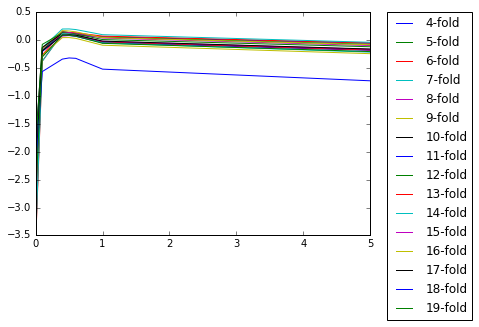

In [90]:
print "LASSO"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.01, .1, .4, .5, .6, 1, 5]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, cancer_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds - minfolds]
    
for i in range(4, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [18]:
# LOOCV 

def loocv_score(x_df,y_df):
    LeaveOneOut
    

### Cardiovascular Diseases
Running Lasso on different values of alpha yields a top cross-validated $r^2$ score of .459, for alpha = .9

LASSO
Best result: 7
[0.069447589783640601, 0.44982246982294011, 0.46591704040853443, 0.46619631137525996, 0.46531781745571144, 0.40135906567904939, -0.028856706072512877, -0.038971246907405784]


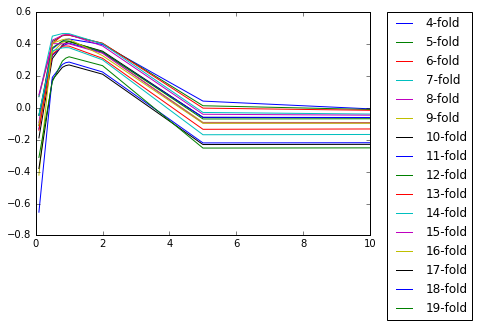

In [88]:
print "LASSO"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.1, .5,.8, .9, 1, 2,5, 10]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4
for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, cardio_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(4, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale("log", nonposx='clip')
plt.show()

In [159]:
print np.mean(cross_val_score(Lasso(alpha = 1), x_df, cardifo_df, cv = LeaveOneOut(156), scoring = 'mean_squared_error'))

-15291.791902


In [21]:
reg = Lasso(alpha = .9, normalize=True)
reg.fit(x_df, cardio_df)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False)

### Diabetes 
Running Lasso on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of .29, for alpha = .1

|alpha = |.001 | .01 | .05 | .1 |.5 | 1 | 10 | 100|
|:---: | :---: | :---: | :---:| :---: |:---: | :---: | :---:| :---: |
|R^2 (Cross-validated)| -8.756 | -1.989 | 0.172 | 0.318|  0.229 | 0.049 | -0.013| -0.013 |

LASSO
Best result: 6
[-0.85615072198091913, 0.20585291020407157, 0.35141190695468999, 0.16818441216842794, -0.013371647827624455, -0.052239676530777213]


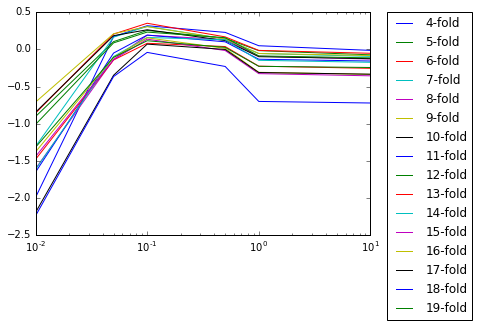

In [104]:
print "LASSO"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.01, .05, .1, .5, 1, 10]
cv_r2 = []
maxr2 = 0
bestfolds = 0
for folds in range(4, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, diabetes_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-4]
    
for i in range(4, 20):
    plt.plot(alphas, cv_r2[i-4], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

## Ridge 

Again, in this section we'd like to try to use Ridge regression to improve the cross-validated $r^2$ for our model and reduce overfitting of the model.
Below is a function we used to calculate the cross-validated r^2 for ridge regression over a number of folds for a certain parameter value.

To summarize, we have:


| |Cardio   |  Diabetes | Cancer  |
|-----|---|---|---|
|$r^2$ (Ridge) |  .424 |  .323 |   .168|

In [25]:
from sklearn.linear_model import Ridge
def ridge_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = Ridge(alpha = param_val, normalize=True)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cardiovascular Diseases
Running Ridge regression on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of .425, for alpha = 1.1

RIDGE
Best result: 6
[-1.7340383032733193, -0.70402253580662844, 0.11659916844483582, 0.444203888038809, 0.44809934156005737, 0.45081526787245974, 0.45368522702542086, 0.45417106541136532, 0.45080458430915754, 0.38046288511540438, 0.28659239461369707, 0.27257102397269772, 0.041173843916365159]


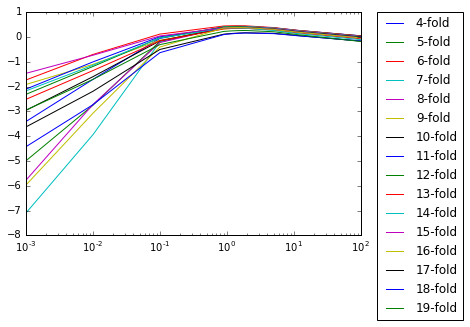

In [91]:
print "RIDGE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.001, .01, .1, .9,1,1.1,1.3,1.5,1.9,5, 10, 11, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
for folds in range(4, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, cardio_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-4]
    
for i in range(4, 20):
    plt.plot(alphas, cv_r2[i-4], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

### Diabetes

Running Lasso on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of .317, for alpha = 1

RIDGE
Best result: 4
[-9.7773517757190689, -3.7662292478774022, -0.27955385769483876, 0.31497930177138955, 0.32121484076935813, 0.32594617307889684, 0.30007224035109331, 0.24636368682169221, 0.054009433566844983, -0.0049850139172748775]


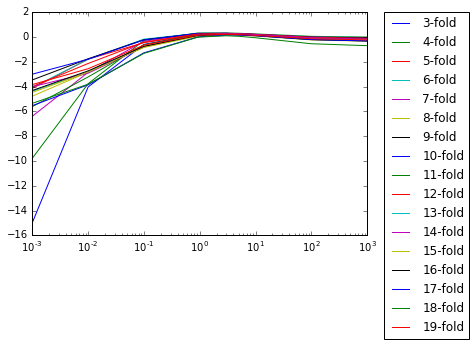

In [94]:
print "RIDGE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.001, .01, .1, .9, 1, 3, 5, 10, 100, 1000]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, diabetes_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

In [28]:
reg = Ridge(alpha = 1, normalize=True)
reg.fit(x_df, diabetes_df)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=None, solver='auto', tol=0.001)

### Cancer

Running Ridge on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of .18, for alpha = 5

RIDGE
Best result: 7
[-6.0441556848916624, -3.7440635353383969, -0.67484626102934708, 0.13633690462447964, 0.21869164076242223, 0.22218574214718742, 0.22060260883510466, 0.19565615321477425, 0.030314423714203627, -0.030750900267758174]


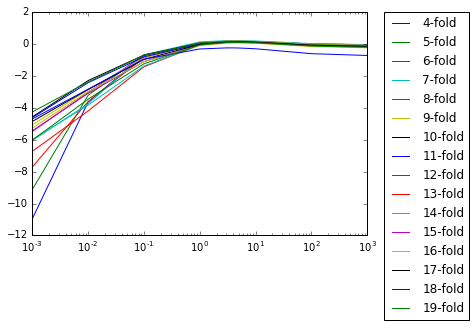

In [96]:
print "RIDGE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.001, .01, .1, 1, 3, 4, 5, 10, 100, 1000]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, cancer_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

---
## Regression Trees
---

In this section, we'll try regression trees to see if they improve our model.

Below, we have a function that we'll use to find the $r^2$ value for a given number of folds and certain hyperparameter.

In [30]:
from sklearn.tree import DecisionTreeRegressor
def rtree_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = DecisionTreeRegressor(max_depth=param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cardiovascular Diseases

For cardiovascular diseases, we see the best $r^2 = .44$ for max_depth = 2. 

RTREE
Best result: 5
[0.42433540322609248, 0.31307890732287202, 0.19283588536590623, 0.1092095516512606, 0.0541058834998576, 0.29118406405801317, 0.22652301673385916, 0.19131931563404775, 0.11683137636311032]


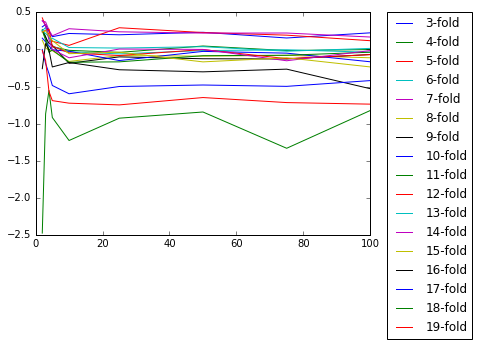

In [98]:
print "RTREE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,cardio_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale("log", nonposx='clip')
plt.show()

### Diabetes

For diabetes, we see the best $r^2$ of $.157$ for a max-depth of 2.

RTREE
Best result: 6
[0.20458419133024122, 0.15208635252283223, 0.14973936386203038, 0.10236577579948997, -0.19876819556686567, -0.25100330095232565, -0.24136942834036487, -0.14435222750270341, -0.30764362810048734]


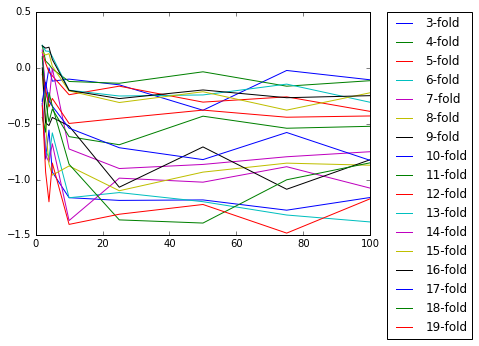

In [99]:
print "RTREE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,diabetes_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale("log", nonposx='clip')
plt.show()

### Cancer

All of the $r^2$ for decision trees on cancer were negative, indicating that these actually perform worse than the null model and as such are not useful models to examine.

RTREE
Best result: -1
[-0.52557329404481123, -0.56169580450851464, -0.7413081295668722, -0.92525207247948615, -1.0618041826541096, -1.0918212684577489, -1.0819359541118827, -0.99488500822823156, -0.96331745856787343]


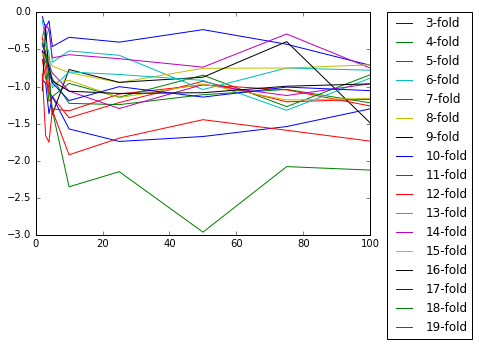

In [101]:
print "RTREE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = -1
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,cancer_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale("log", nonposx='clip')
plt.show()